# Parking_Demand_Predict

[주차수요 예측 AI 경진대회](https://dacon.io/competitions/official/235745/overview/description)

# import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import koreanize_matplotlib
%config InlineBackend.figure_format = 'retina'

pd.options.display.float_format = '{:.4f}'.format
data_path = "./data/"
train_file = f"{data_path}train.csv"
test_file = f"{data_path}test.csv"
sample_submit_file = f"{data_path}sample_submission.csv"

In [2]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

# Load Data

In [3]:
train = reduce_mem_usage(pd.read_csv(train_file, index_col=False))
test = reduce_mem_usage(pd.read_csv(test_file))

print(train.shape, test.shape)
print(set(train.columns) - set(test.columns))
display(train.head())

Mem. usage decreased to  0.20 Mb (40.0% reduction)
Mem. usage decreased to  0.07 Mb (37.5% reduction)
(2952, 15) (1022, 14)
{'등록차량수'}


,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,등록차량수
0,C2483,900,아파트,경상북도,국민임대,39.7188,134,38.0000,A,15667000,103680,0.0000,3.0000,1425.0000,1015.0000
1,C2483,900,아파트,경상북도,국민임대,39.7188,15,38.0000,A,15667000,103680,0.0000,3.0000,1425.0000,1015.0000
2,C2483,900,아파트,경상북도,국민임대,51.9375,385,38.0000,A,27304000,184330,0.0000,3.0000,1425.0000,1015.0000
3,C2483,900,아파트,경상북도,국민임대,51.9375,15,38.0000,A,27304000,184330,0.0000,3.0000,1425.0000,1015.0000
4,C2483,900,아파트,경상북도,국민임대,51.9375,41,38.0000,A,27304000,184330,0.0000,3.0000,1425.0000,1015.0000


In [4]:
label = "등록차량수"

In [5]:
# 에러 데이터 제거

error_data = ['C2085', 'C1397', 'C2431', 'C1649', 'C1095', 'C2051', 'C1218', 'C1894', 'C2483', 'C1502', 'C1988']

for error in error_data:
    error_index = train[train['단지코드'] == error].index
    train.drop(error_index, inplace=True)

In [6]:
display(train.info())

display(train.describe().T)

display(train.describe(include="O").T)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2876 entries, 8 to 2951
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   단지코드                          2876 non-null   object 
 1   총세대수                          2876 non-null   int16  
 2   임대건물구분                        2876 non-null   object 
 3   지역                            2876 non-null   object 
 4   공급유형                          2876 non-null   object 
 5   전용면적                          2876 non-null   float16
 6   전용면적별세대수                      2876 non-null   int16  
 7   공가수                           2876 non-null   float16
 8   자격유형                          2876 non-null   object 
 9   임대보증금                         2307 non-null   object 
 10  임대료                           2307 non-null   object 
 11  도보 10분거리 내 지하철역 수(환승노선 수 반영)  2669 non-null   float16
 12  도보 10분거리 내 버스정류장 수            2876 non-null   float16
 13  단지내

None

,count,mean,std,min,25%,50%,75%,max
총세대수,2876.0000,887.2997,517.2142,26.0000,514.0000,775.0000,1100.5000,2568.0000
전용면적,2876.0000,inf,inf,12.6172,32.0938,39.8438,51.0703,583.5000
전용면적별세대수,2876.0000,102.7079,133.1522,1.0000,14.0000,60.0000,142.2500,1865.0000
공가수,2876.0000,12.9141,10.6719,0.0000,4.0000,11.0000,20.0000,55.0000
도보 10분거리 내 지하철역 수(환승노선 수 반영),2669.0000,0.1814,0.4321,0.0000,0.0000,0.0000,0.0000,3.0000
도보 10분거리 내 버스정류장 수,2876.0000,3.7070,2.6738,0.0000,2.0000,3.0000,4.0000,20.0000
단지내주차면수,2876.0000,inf,inf,13.0000,277.0000,502.0000,813.2500,1798.0000
등록차량수,2876.0000,inf,inf,13.0000,209.0000,480.0000,762.0000,2550.0000


,count,unique,top,freq
단지코드,2876,412,C1439,48
임대건물구분,2876,2,아파트,2314
지역,2876,16,경기도,602
공급유형,2876,10,국민임대,1734
자격유형,2876,15,A,1736
임대보증금,2307,926,24775000,22
임대료,2307,965,390000,19


## 중복 제거

In [7]:
print(train.shape, train.drop_duplicates().shape)
print(test.shape, test.drop_duplicates().shape)

(2876, 15) (2552, 15)
(1022, 14) (949, 14)


In [8]:
train = train.drop_duplicates()
test = test.drop_duplicates()

In [9]:
print(train.shape, train.drop_duplicates().shape)
print(test.shape, test.drop_duplicates().shape)

(2552, 15) (2552, 15)
(949, 14) (949, 14)


## 탐색

In [10]:
display(train.info())

display(train.describe().T)

display(train.describe(include="O").T)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2552 entries, 8 to 2951
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   단지코드                          2552 non-null   object 
 1   총세대수                          2552 non-null   int16  
 2   임대건물구분                        2552 non-null   object 
 3   지역                            2552 non-null   object 
 4   공급유형                          2552 non-null   object 
 5   전용면적                          2552 non-null   float16
 6   전용면적별세대수                      2552 non-null   int16  
 7   공가수                           2552 non-null   float16
 8   자격유형                          2552 non-null   object 
 9   임대보증금                         2260 non-null   object 
 10  임대료                           2260 non-null   object 
 11  도보 10분거리 내 지하철역 수(환승노선 수 반영)  2401 non-null   float16
 12  도보 10분거리 내 버스정류장 수            2552 non-null   float16
 13  단지내

None

,count,mean,std,min,25%,50%,75%,max
총세대수,2552.0000,854.0435,487.8448,26.0000,504.0000,772.0000,1058.0000,2568.0000
전용면적,2552.0000,inf,inf,12.6172,36.4688,46.2188,51.7500,583.5000
전용면적별세대수,2552.0000,114.7190,136.4657,1.0000,26.0000,78.0000,154.0000,1865.0000
공가수,2552.0000,13.3281,10.5000,0.0000,4.0000,13.0000,20.0000,55.0000
도보 10분거리 내 지하철역 수(환승노선 수 반영),2401.0000,0.1625,0.4226,0.0000,0.0000,0.0000,0.0000,3.0000
도보 10분거리 내 버스정류장 수,2552.0000,3.7031,2.7188,0.0000,2.0000,3.0000,4.0000,20.0000
단지내주차면수,2552.0000,inf,inf,13.0000,330.0000,548.0000,862.0000,1798.0000
등록차량수,2552.0000,inf,inf,13.0000,284.0000,509.0000,793.0000,2550.0000


,count,unique,top,freq
단지코드,2552,412,C2132,31
임대건물구분,2552,2,아파트,2267
지역,2552,16,경기도,590
공급유형,2552,10,국민임대,1706
자격유형,2552,15,A,1706
임대보증금,2260,926,24775000,22
임대료,2260,965,390000,19


array([[<AxesSubplot:title={'center':'총세대수'}>,
        <AxesSubplot:title={'center':'전용면적'}>,
        <AxesSubplot:title={'center':'전용면적별세대수'}>],
       [<AxesSubplot:title={'center':'공가수'}>,
        <AxesSubplot:title={'center':'도보 10분거리 내 지하철역 수(환승노선 수 반영)'}>,
        <AxesSubplot:title={'center':'도보 10분거리 내 버스정류장 수'}>],
       [<AxesSubplot:title={'center':'단지내주차면수'}>,
        <AxesSubplot:title={'center':'등록차량수'}>, <AxesSubplot:>]],
      dtype=object)

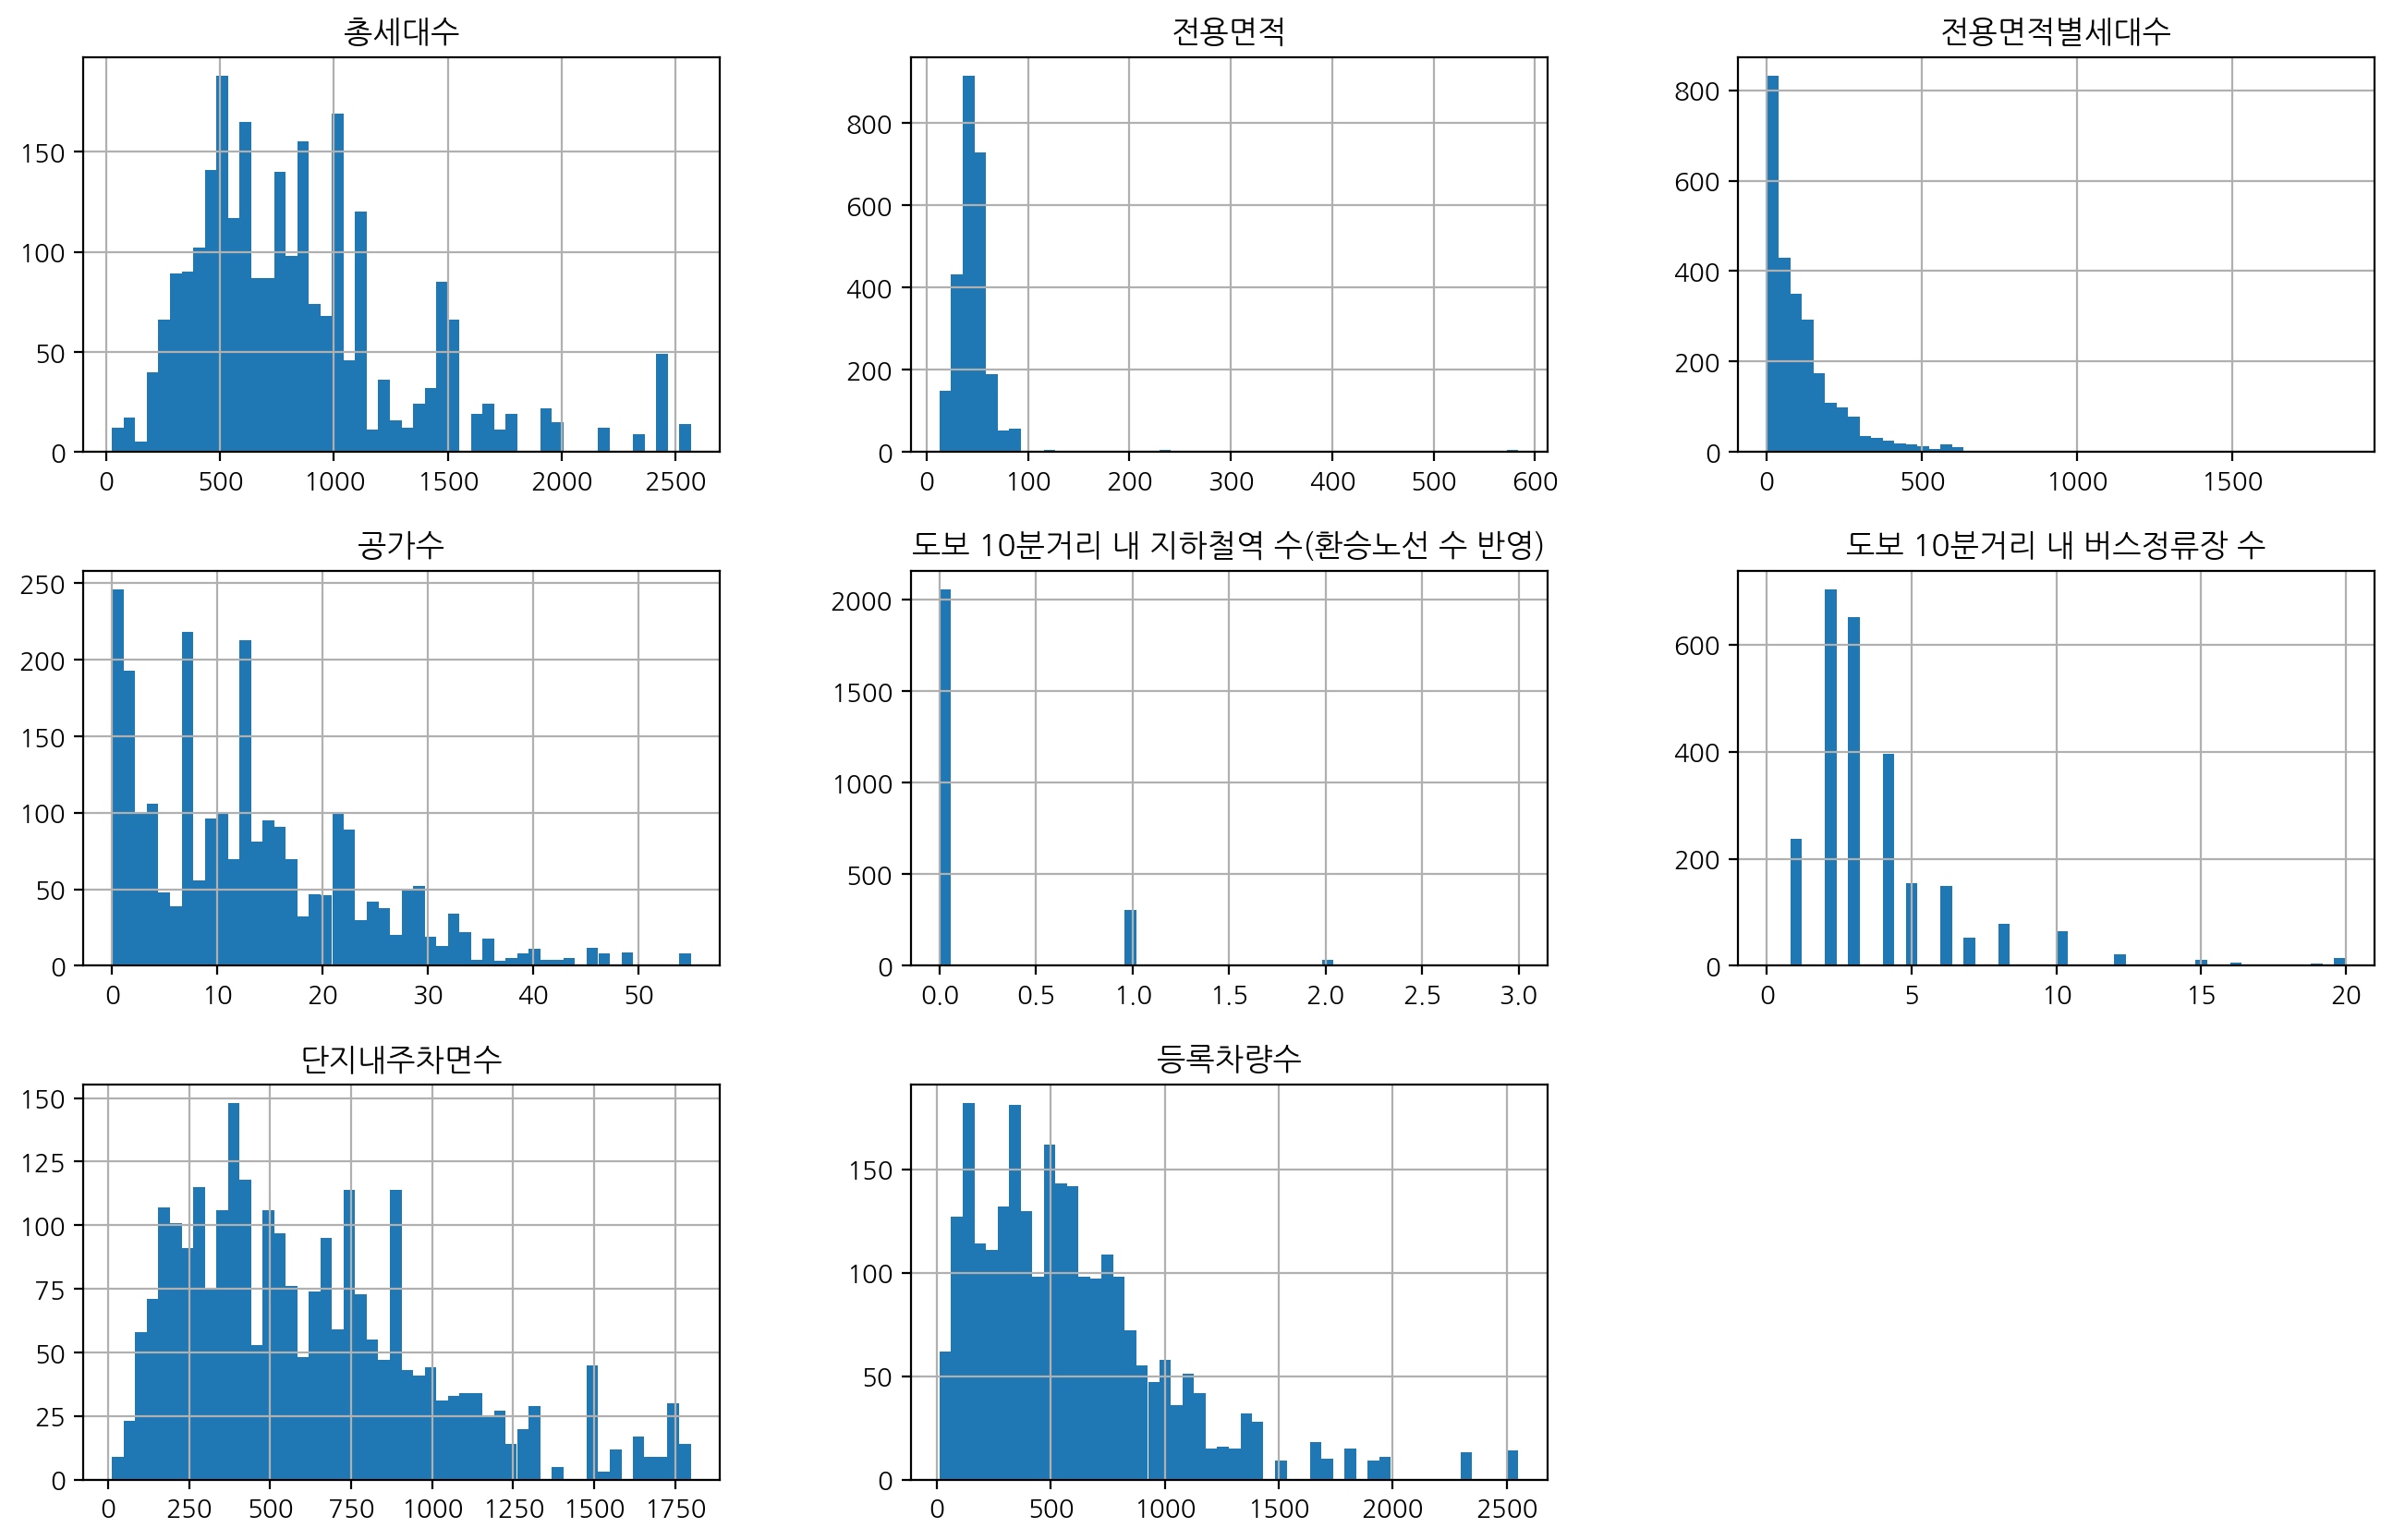

In [11]:
train.hist(figsize=(16,10), bins=50)

# Preprocessing

## 결측치

In [12]:
display(train.isnull().sum())

display(test.isnull().sum())

단지코드                              0
총세대수                              0
임대건물구분                            0
지역                                0
공급유형                              0
전용면적                              0
전용면적별세대수                          0
공가수                               0
자격유형                              0
임대보증금                           292
임대료                             292
도보 10분거리 내 지하철역 수(환승노선 수 반영)    151
도보 10분거리 내 버스정류장 수                0
단지내주차면수                           0
등록차량수                             0
dtype: int64

단지코드                              0
총세대수                              0
임대건물구분                            0
지역                                0
공급유형                              0
전용면적                              0
전용면적별세대수                          0
공가수                               0
자격유형                              2
임대보증금                           114
임대료                             114
도보 10분거리 내 지하철역 수(환승노선 수 반영)     34
도보 10분거리 내 버스정류장 수                0
단지내주차면수                           0
dtype: int64

In [13]:
train[["도보 10분거리 내 지하철역 수(환승노선 수 반영)", "도보 10분거리 내 버스정류장 수"]] = (
    train[["도보 10분거리 내 지하철역 수(환승노선 수 반영)", "도보 10분거리 내 버스정류장 수"]]
    .fillna(0)
    .astype(np.uint8)
)
train["임대보증금"] = train["임대보증금"].replace("-", 0)
train["임대료"] = train["임대료"].replace("-", 0)
train[["임대보증금", "임대료"]] = train[["임대보증금", "임대료"]].fillna(0).astype(np.uint64)
display(train.isnull().sum())

단지코드                            0
총세대수                            0
임대건물구분                          0
지역                              0
공급유형                            0
전용면적                            0
전용면적별세대수                        0
공가수                             0
자격유형                            0
임대보증금                           0
임대료                             0
도보 10분거리 내 지하철역 수(환승노선 수 반영)    0
도보 10분거리 내 버스정류장 수              0
단지내주차면수                         0
등록차량수                           0
dtype: int64

In [14]:
test[["도보 10분거리 내 지하철역 수(환승노선 수 반영)", "도보 10분거리 내 버스정류장 수"]] = (
    test[["도보 10분거리 내 지하철역 수(환승노선 수 반영)", "도보 10분거리 내 버스정류장 수"]]
    .fillna(0)
    .astype(np.uint8)
)
test["임대보증금"] = test["임대보증금"].replace("-", 0)
test["임대료"] = test["임대료"].replace("-", 0)
test[["임대보증금", "임대료"]] = test[["임대보증금", "임대료"]].fillna(0).astype(np.uint64)
display(test.isnull().sum())

단지코드                            0
총세대수                            0
임대건물구분                          0
지역                              0
공급유형                            0
전용면적                            0
전용면적별세대수                        0
공가수                             0
자격유형                            2
임대보증금                           0
임대료                             0
도보 10분거리 내 지하철역 수(환승노선 수 반영)    0
도보 10분거리 내 버스정류장 수              0
단지내주차면수                         0
dtype: int64

In [15]:
display(train.info())

display(train.describe().T)

display(train.describe(include="O").T)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2552 entries, 8 to 2951
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   단지코드                          2552 non-null   object 
 1   총세대수                          2552 non-null   int16  
 2   임대건물구분                        2552 non-null   object 
 3   지역                            2552 non-null   object 
 4   공급유형                          2552 non-null   object 
 5   전용면적                          2552 non-null   float16
 6   전용면적별세대수                      2552 non-null   int16  
 7   공가수                           2552 non-null   float16
 8   자격유형                          2552 non-null   object 
 9   임대보증금                         2552 non-null   uint64 
 10  임대료                           2552 non-null   uint64 
 11  도보 10분거리 내 지하철역 수(환승노선 수 반영)  2552 non-null   uint8  
 12  도보 10분거리 내 버스정류장 수            2552 non-null   uint8  
 13  단지내

None

,count,mean,std,min,25%,50%,75%,max
총세대수,2552.0000,854.0435,487.8448,26.0000,504.0000,772.0000,1058.0000,2568.0000
전용면적,2552.0000,inf,inf,12.6172,36.4688,46.2188,51.7500,583.5000
전용면적별세대수,2552.0000,114.7190,136.4657,1.0000,26.0000,78.0000,154.0000,1865.0000
공가수,2552.0000,13.3281,10.5000,0.0000,4.0000,13.0000,20.0000,55.0000
임대보증금,2552.0000,22743702.6646,20219580.8515,0.0000,11426000.0000,18581000.0000,28856000.0000,213863000.0000
임대료,2552.0000,167509.1458,132670.1364,0.0000,90110.0000,144180.0000,217210.0000,1058030.0000
도보 10분거리 내 지하철역 수(환승노선 수 반영),2552.0000,0.1528,0.4117,0.0000,0.0000,0.0000,0.0000,3.0000
도보 10분거리 내 버스정류장 수,2552.0000,3.7022,2.7184,0.0000,2.0000,3.0000,4.0000,20.0000
단지내주차면수,2552.0000,inf,inf,13.0000,330.0000,548.0000,862.0000,1798.0000
등록차량수,2552.0000,inf,inf,13.0000,284.0000,509.0000,793.0000,2550.0000


,count,unique,top,freq
단지코드,2552,412,C2132,31
임대건물구분,2552,2,아파트,2267
지역,2552,16,경기도,590
공급유형,2552,10,국민임대,1706
자격유형,2552,15,A,1706


In [16]:
test[test["자격유형"].isnull() == True]

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수
196,C2411,962,아파트,경상남도,국민임대,46.9062,240,25.0000,NaN,71950000,37470,0,2,840.0000
258,C2253,1161,아파트,강원도,영구임대,26.3750,745,0.0000,NaN,2249000,44770,0,2,173.0000


In [17]:
test[test["단지코드"] == 'C2411']

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수
193,C2411,962,아파트,경상남도,국민임대,39.4375,56,25.0000,A,11992000,100720,0,2,840.0000
194,C2411,962,아파트,경상남도,국민임대,39.7188,336,25.0000,A,11992000,100720,0,2,840.0000
195,C2411,962,아파트,경상남도,국민임대,39.8125,179,25.0000,A,11992000,100720,0,2,840.0000
196,C2411,962,아파트,경상남도,국민임대,46.9062,240,25.0000,NaN,71950000,37470,0,2,840.0000
197,C2411,962,아파트,경상남도,국민임대,51.9375,150,25.0000,A,21586000,171480,0,2,840.0000


In [18]:
test.loc[test["단지코드"].isin(["C2411"]) & test["자격유형"].isnull(), "자격유형"] = "A"

In [19]:
test[test["단지코드"] == 'C2253']

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수
258,C2253,1161,아파트,강원도,영구임대,26.3750,745,0.0000,NaN,2249000,44770,0,2,173.0000
259,C2253,1161,아파트,강원도,영구임대,31.3125,239,0.0000,C,3731000,83020,0,2,173.0000
260,C2253,1161,아파트,강원도,영구임대,31.3125,149,0.0000,C,3731000,83020,0,2,173.0000
261,C2253,1161,상가,강원도,임대상가,13.7734,1,0.0000,D,0,0,0,2,173.0000
262,C2253,1161,상가,강원도,임대상가,22.8906,1,0.0000,D,0,0,0,2,173.0000
263,C2253,1161,상가,강원도,임대상가,22.9062,1,0.0000,D,0,0,0,2,173.0000
264,C2253,1161,상가,강원도,임대상가,23.7969,1,0.0000,D,0,0,0,2,173.0000
266,C2253,1161,상가,강원도,임대상가,23.8594,1,0.0000,D,0,0,0,2,173.0000
268,C2253,1161,상가,강원도,임대상가,24.1875,1,0.0000,D,0,0,0,2,173.0000
269,C2253,1161,상가,강원도,임대상가,27.7500,1,0.0000,D,0,0,0,2,173.0000


In [20]:
test.loc[test["단지코드"].isin(["C2253"]) & test["자격유형"].isnull(), "자격유형"] = test[
    (test["단지코드"] == "C2253") & (test["공급유형"] == "영구임대")
]["자격유형"].mode()[0]

## 스케일링

In [21]:
scailing_features = train.drop(columns="등록차량수").select_dtypes("number").columns.to_list()

print(scailing_features)

['총세대수', '전용면적', '전용면적별세대수', '공가수', '임대보증금', '임대료', '도보 10분거리 내 지하철역 수(환승노선 수 반영)', '도보 10분거리 내 버스정류장 수', '단지내주차면수']


In [22]:
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler().fit(train[scailing_features])

train[scailing_features] = scaler.transform(train[scailing_features])
test[scailing_features] = scaler.transform(test[scailing_features])

display(train[scailing_features].head())

,총세대수,전용면적,전용면적별세대수,공가수,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수
8,-0.4097,-0.8344,1.5469,0.2500,-0.5373,-0.4818,0.0000,0.0000,0.1429
9,-0.4097,-0.4335,-0.1406,0.2500,-0.3390,-0.2915,0.0000,0.0000,0.1429
10,-0.4097,-0.4335,-0.4531,0.2500,-0.3390,-0.2915,0.0000,0.0000,0.1429
11,-0.4097,0.0450,-0.3125,0.2500,-0.0085,0.0439,0.0000,0.0000,0.1429
12,-0.4097,0.0450,-0.4609,0.2500,-0.0085,0.0439,0.0000,0.0000,0.1429


# FE

In [23]:
train.groupby(['단지코드']).nunique(dropna=False)

,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,등록차량수
단지코드,,,,,,,,,,,,,,
C1000,1,1,1,1,5,6,1,1,3,3,1,1,1,1
C1004,1,2,1,2,15,3,1,2,3,3,1,1,1,1
C1005,1,1,1,1,3,3,1,1,3,3,1,1,1,1
C1013,1,1,1,1,4,5,1,1,3,3,1,1,1,1
C1014,1,1,1,1,6,7,1,1,4,4,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
C2663,1,1,1,1,5,6,1,1,4,4,1,1,1,1
C2666,1,1,1,1,4,6,1,1,2,2,1,1,1,1
C2670,1,1,1,1,4,3,1,1,3,3,1,1,1,1


In [24]:
train.groupby(['단지코드']).nunique(dropna=False).sum(axis=0)

총세대수                             412
임대건물구분                           445
지역                               412
공급유형                             476
전용면적                            1806
전용면적별세대수                        2162
공가수                              412
자격유형                             499
임대보증금                           1237
임대료                             1251
도보 10분거리 내 지하철역 수(환승노선 수 반영)     412
도보 10분거리 내 버스정류장 수               412
단지내주차면수                          412
등록차량수                            412
dtype: int64

## 공급유형

In [25]:
pd.concat([train.공급유형.value_counts(), test.공급유형.value_counts()], axis=1)

,공급유형,공급유형
국민임대,1706,619.0000
임대상가,285,112.0000
행복주택,192,121.0000
공공임대(10년),169,34.0000
영구임대,149,44.0000
공공임대(50년),31,13.0000
공공임대(분납),7,6.0000
공공분양,7,NaN
장기전세,3,NaN
공공임대(5년),3,NaN


In [26]:
train.loc[train.공급유형.isin(['공공임대(5년)', '공공분양', '공공임대(10년)', '공공임대(분납)']), '공급유형'] = '공공임대(5년/10년/분납/분양)'
test.loc[test.공급유형.isin(['공공임대(5년)', '공공분양', '공공임대(10년)', '공공임대(분납)']), '공급유형'] = '공공임대(5년/10년/분납/분양)'
train.loc[train.공급유형.isin(['장기전세', '국민임대']), '공급유형'] = '국민임대/장기전세'
test.loc[test.공급유형.isin(['장기전세', '국민임대']), '공급유형'] = '국민임대/장기전세'
set(train.공급유형), set(test.공급유형)

({'공공임대(50년)', '공공임대(5년/10년/분납/분양)', '국민임대/장기전세', '영구임대', '임대상가', '행복주택'},
 {'공공임대(50년)', '공공임대(5년/10년/분납/분양)', '국민임대/장기전세', '영구임대', '임대상가', '행복주택'})

## 자격유형

+ 'H', 'B', 'E', 'G' 는 국민임대/장기전세 공급대상(E는 영구임대인 경우도 있긴 하지만 국민임대/장기전세인 경우가 더 많아서 여기에 포함시킴)
+ 'C', 'I', 'F', 'G' 는 영구임대 공급대상으로 묶어 보겠음

In [27]:
train.loc[train.자격유형.isin(['J', 'L', 'K', 'N', 'M', 'O']), '자격유형'] = '행복주택_공급대상'
test.loc[test.자격유형.isin(['J', 'L', 'K', 'N', 'M', 'O']), '자격유형'] = '행복주택_공급대상'

train.loc[train.자격유형.isin(['H', 'B', 'E', 'G']), '자격유형'] = '국민임대/장기전세_공급대상'
test.loc[test.자격유형.isin(['H', 'B', 'E', 'G']), '자격유형'] = '국민임대/장기전세_공급대상'

train.loc[train.자격유형.isin(['C', 'I', 'F']), '자격유형'] = '영구임대_공급대상'
test.loc[test.자격유형.isin(['C', 'I', 'F']), '자격유형'] = '영구임대_공급대상'

pd.concat([train.자격유형.value_counts(), 
           test.자격유형.value_counts()], axis=1)

,자격유형,자격유형
A,1706,569
D,292,114
국민임대/장기전세_공급대상,218,103
행복주택_공급대상,192,121
영구임대_공급대상,144,42


# Encoding

In [28]:
train.groupby(['단지코드']).nunique(dropna=False)

,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,등록차량수
단지코드,,,,,,,,,,,,,,
C1000,1,1,1,1,5,6,1,1,3,3,1,1,1,1
C1004,1,2,1,2,15,3,1,2,3,3,1,1,1,1
C1005,1,1,1,1,3,3,1,1,3,3,1,1,1,1
C1013,1,1,1,1,4,5,1,1,3,3,1,1,1,1
C1014,1,1,1,1,6,7,1,1,4,4,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
C2663,1,1,1,1,5,6,1,1,4,4,1,1,1,1
C2666,1,1,1,1,4,6,1,1,2,2,1,1,1,1
C2670,1,1,1,1,4,3,1,1,3,3,1,1,1,1


In [29]:
train.groupby(['단지코드']).nunique(dropna=False).sum(axis=0)

총세대수                             412
임대건물구분                           445
지역                               412
공급유형                             472
전용면적                            1806
전용면적별세대수                        2162
공가수                              412
자격유형                             490
임대보증금                           1237
임대료                             1251
도보 10분거리 내 지하철역 수(환승노선 수 반영)     412
도보 10분거리 내 버스정류장 수               412
단지내주차면수                          412
등록차량수                            412
dtype: int64

In [30]:
non_fe_col = ["단지코드", "총세대수", "지역", "공가수", "도보 10분거리 내 지하철역 수(환승노선 수 반영)", "도보 10분거리 내 버스정류장 수", "단지내주차면수", "등록차량수"]

train_fe = train[non_fe_col].set_index('단지코드').drop_duplicates()
test_fe = test[[col for col in non_fe_col if col!='등록차량수']].set_index('단지코드').drop_duplicates()
display(train_fe.head())

,총세대수,지역,공가수,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,등록차량수
단지코드,,,,,,,
C2515,-0.4097,경상남도,0.2500,0.0000,0.0000,0.1429,205.0000
C1407,0.8014,대전광역시,0.0000,1.0000,-1.0000,1.3853,1064.0000
C1945,-0.0307,경기도,-0.4375,1.0000,0.0000,0.3496,730.0000
C1470,-0.1372,전라북도,0.0625,0.0000,-0.5000,0.1823,553.0000
C1898,-0.3718,전라북도,-0.2500,0.0000,1.5000,-0.0583,415.0000


In [31]:
def reshape_cat_features(data, cast_col, value_col):
    res = data.drop_duplicates(['단지코드', cast_col]).assign(counter=1).pivot(index='단지코드', columns=cast_col, values=value_col).fillna(0)
    res.columns.name = None
    res = res.rename(columns={col:cast_col+'_'+col for col in res.columns}).astype(np.int8)
    return res

In [32]:
train_fe = pd.concat([train_fe,
                       reshape_cat_features(data=train, cast_col='임대건물구분', value_col='counter'),
                       reshape_cat_features(data=train, cast_col='공급유형', value_col='counter'),
                       reshape_cat_features(data=train, cast_col='자격유형', value_col='counter')], axis=1)

test_fe = pd.concat([test_fe,
                       reshape_cat_features(data=test, cast_col='임대건물구분', value_col='counter'),
                       reshape_cat_features(data=test, cast_col='공급유형', value_col='counter'),
                       reshape_cat_features(data=test, cast_col='자격유형', value_col='counter')], axis=1)

print(train_fe.shape, test_fe.shape)


display(train_fe.head())
display(test_fe.head())

(412, 20) (150, 19)


,총세대수,지역,공가수,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,등록차량수,임대건물구분_상가,임대건물구분_아파트,공급유형_공공임대(50년),공급유형_공공임대(5년/10년/분납/분양),공급유형_국민임대/장기전세,공급유형_영구임대,공급유형_임대상가,공급유형_행복주택,자격유형_A,자격유형_D,자격유형_국민임대/장기전세_공급대상,자격유형_영구임대_공급대상,자격유형_행복주택_공급대상
단지코드,,,,,,,,,,,,,,,,,,,,
C2515,-0.4097,경상남도,0.2500,0.0000,0.0000,0.1429,205.0000,0,1,0,0,1,0,0,0,1,0,0,0,0
C1407,0.8014,대전광역시,0.0000,1.0000,-1.0000,1.3853,1064.0000,0,1,0,0,1,0,0,0,1,0,0,0,0
C1945,-0.0307,경기도,-0.4375,1.0000,0.0000,0.3496,730.0000,0,1,0,0,1,0,0,0,0,0,1,0,0
C1470,-0.1372,전라북도,0.0625,0.0000,-0.5000,0.1823,553.0000,0,1,0,0,1,0,0,0,1,0,0,0,0
C1898,-0.3718,전라북도,-0.2500,0.0000,1.5000,-0.0583,415.0000,0,1,0,0,1,0,0,0,1,0,0,0,0


,총세대수,지역,공가수,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,임대건물구분_상가,임대건물구분_아파트,공급유형_공공임대(50년),공급유형_공공임대(5년/10년/분납/분양),공급유형_국민임대/장기전세,공급유형_영구임대,공급유형_임대상가,공급유형_행복주택,자격유형_A,자격유형_D,자격유형_국민임대/장기전세_공급대상,자격유형_영구임대_공급대상,자격유형_행복주택_공급대상
단지코드,,,,,,,,,,,,,,,,,,,
C1072,-0.0325,경기도,0.0625,0.0000,-0.5000,0.2538,0,1,0,0,1,0,0,0,1,0,1,0,0
C1128,1.0505,경기도,-0.2500,0.0000,0.0000,1.2556,0,1,0,0,1,0,0,0,1,0,1,0,0
C1456,-0.2762,부산광역시,0.3125,0.0000,6.5000,-0.0019,0,1,0,0,1,0,0,0,1,0,0,0,0
C1840,-0.3231,전라북도,-0.3750,0.0000,0.0000,-0.0094,0,1,0,0,1,0,0,0,1,0,0,0,0
C1332,0.9477,경기도,-0.1250,0.0000,-0.5000,1.0602,0,1,0,0,1,0,0,0,0,0,1,0,0


# corr

In [33]:
corr_col = "단지코드"
corr_col = [x for x in non_fe_col if x != corr_col]
print(corr_col)

corr = pd.DataFrame(train_fe[corr_col].drop(columns = label).corrwith(train_fe[label]))
corr_sort_abs = corr.sort_values(by=0, ascending=0, key=abs)
display(corr_sort_abs)

['총세대수', '지역', '공가수', '도보 10분거리 내 지하철역 수(환승노선 수 반영)', '도보 10분거리 내 버스정류장 수', '단지내주차면수', '등록차량수']


,0
단지내주차면수,0.8479
총세대수,0.5923
공가수,0.1779
도보 10분거리 내 버스정류장 수,0.1151
도보 10분거리 내 지하철역 수(환승노선 수 반영),-0.0085


<AxesSubplot:>

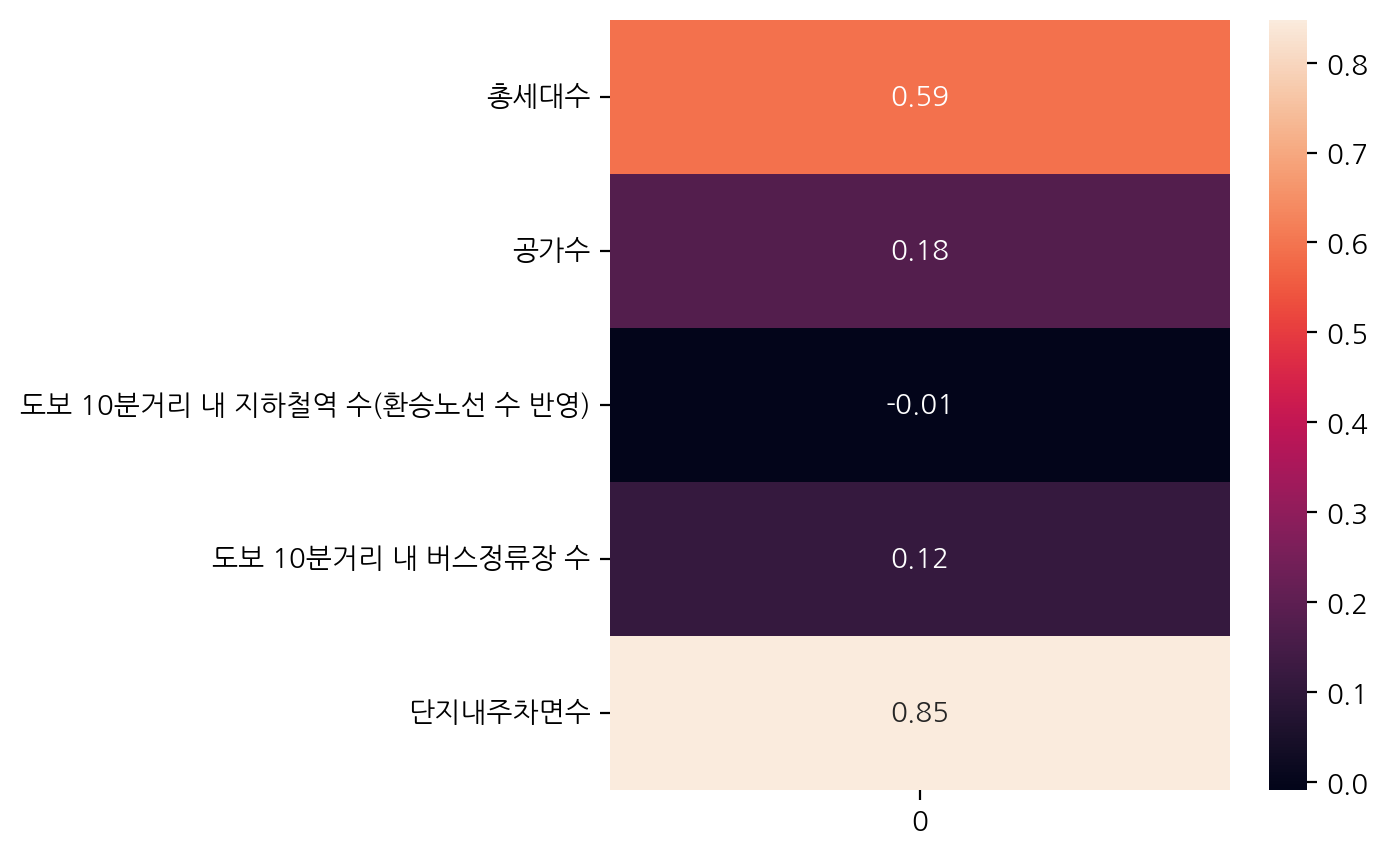

In [34]:
plt.figure(figsize = (5, 5))
sns.heatmap(data = corr, annot = True, fmt = '.2f')

In [35]:
corr_high = corr.loc[np.abs(corr_sort_abs[0]) > 0.1]
display(corr_high)
print(len(corr_high.index.to_list()))

,0
총세대수,0.5923
공가수,0.1779
도보 10분거리 내 버스정류장 수,0.1151
단지내주차면수,0.8479


4


<AxesSubplot:>

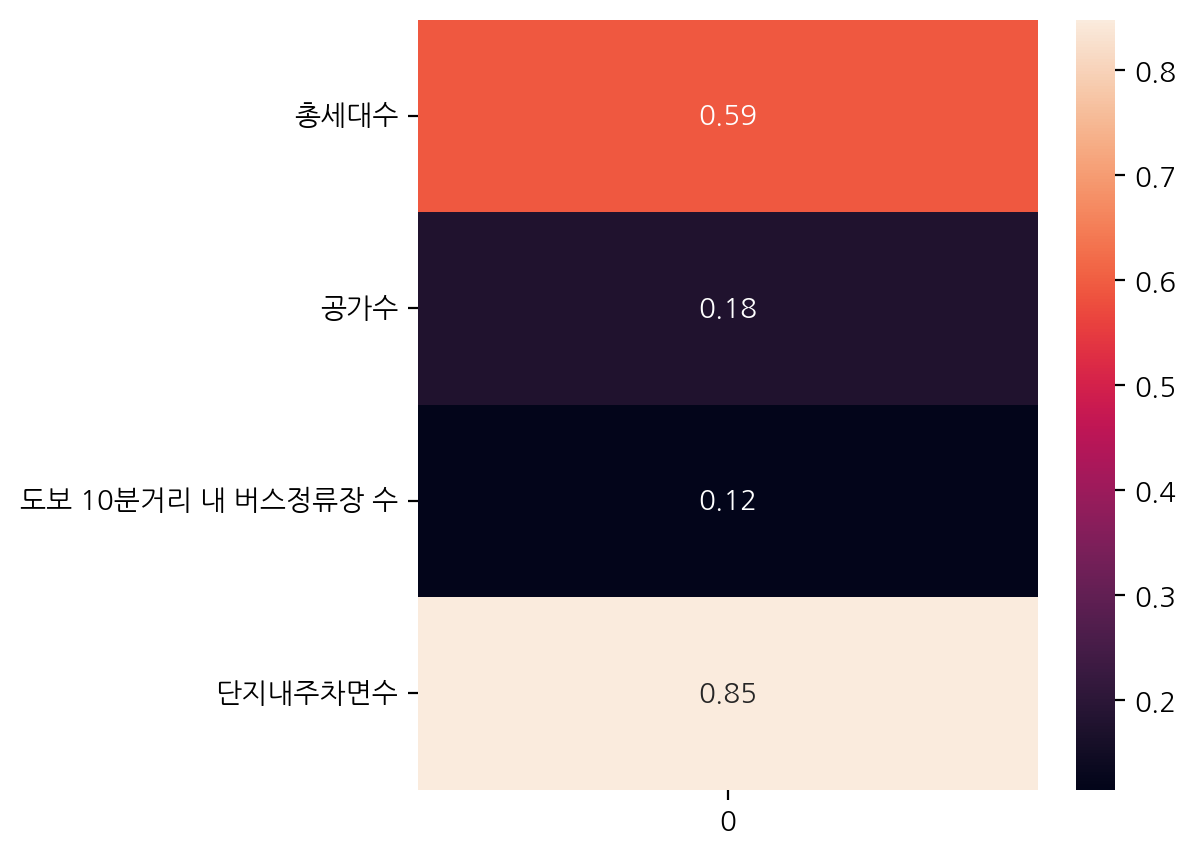

In [36]:
plt.figure(figsize = (5, 5))
sns.heatmap(data = corr_high, annot = True, fmt = '.2f')

# ML

## Dataset

In [37]:
display(train_fe.head())

,총세대수,지역,공가수,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,등록차량수,임대건물구분_상가,임대건물구분_아파트,공급유형_공공임대(50년),공급유형_공공임대(5년/10년/분납/분양),공급유형_국민임대/장기전세,공급유형_영구임대,공급유형_임대상가,공급유형_행복주택,자격유형_A,자격유형_D,자격유형_국민임대/장기전세_공급대상,자격유형_영구임대_공급대상,자격유형_행복주택_공급대상
단지코드,,,,,,,,,,,,,,,,,,,,
C2515,-0.4097,경상남도,0.2500,0.0000,0.0000,0.1429,205.0000,0,1,0,0,1,0,0,0,1,0,0,0,0
C1407,0.8014,대전광역시,0.0000,1.0000,-1.0000,1.3853,1064.0000,0,1,0,0,1,0,0,0,1,0,0,0,0
C1945,-0.0307,경기도,-0.4375,1.0000,0.0000,0.3496,730.0000,0,1,0,0,1,0,0,0,0,0,1,0,0
C1470,-0.1372,전라북도,0.0625,0.0000,-0.5000,0.1823,553.0000,0,1,0,0,1,0,0,0,1,0,0,0,0
C1898,-0.3718,전라북도,-0.2500,0.0000,1.5000,-0.0583,415.0000,0,1,0,0,1,0,0,0,1,0,0,0,0


In [38]:
display(test_fe.head())

,총세대수,지역,공가수,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,임대건물구분_상가,임대건물구분_아파트,공급유형_공공임대(50년),공급유형_공공임대(5년/10년/분납/분양),공급유형_국민임대/장기전세,공급유형_영구임대,공급유형_임대상가,공급유형_행복주택,자격유형_A,자격유형_D,자격유형_국민임대/장기전세_공급대상,자격유형_영구임대_공급대상,자격유형_행복주택_공급대상
단지코드,,,,,,,,,,,,,,,,,,,
C1072,-0.0325,경기도,0.0625,0.0000,-0.5000,0.2538,0,1,0,0,1,0,0,0,1,0,1,0,0
C1128,1.0505,경기도,-0.2500,0.0000,0.0000,1.2556,0,1,0,0,1,0,0,0,1,0,1,0,0
C1456,-0.2762,부산광역시,0.3125,0.0000,6.5000,-0.0019,0,1,0,0,1,0,0,0,1,0,0,0,0
C1840,-0.3231,전라북도,-0.3750,0.0000,0.0000,-0.0094,0,1,0,0,1,0,0,0,1,0,0,0,0
C1332,0.9477,경기도,-0.1250,0.0000,-0.5000,1.0602,0,1,0,0,1,0,0,0,0,0,1,0,0


In [39]:
train_fe.columns.to_list()

['총세대수',
 '지역',
 '공가수',
 '도보 10분거리 내 지하철역 수(환승노선 수 반영)',
 '도보 10분거리 내 버스정류장 수',
 '단지내주차면수',
 '등록차량수',
 '임대건물구분_상가',
 '임대건물구분_아파트',
 '공급유형_공공임대(50년)',
 '공급유형_공공임대(5년/10년/분납/분양)',
 '공급유형_국민임대/장기전세',
 '공급유형_영구임대',
 '공급유형_임대상가',
 '공급유형_행복주택',
 '자격유형_A',
 '자격유형_D',
 '자격유형_국민임대/장기전세_공급대상',
 '자격유형_영구임대_공급대상',
 '자격유형_행복주택_공급대상']

In [40]:
cat_features = ["지역"]
fe_features = [
    "임대건물구분_상가",
    "임대건물구분_아파트",
    "공급유형_공공임대(50년)",
    "공급유형_공공임대(5년/10년/분납/분양)",
    "공급유형_국민임대/장기전세",
    "공급유형_영구임대",
    "공급유형_임대상가",
    "공급유형_행복주택",
    "자격유형_A",
    "자격유형_D",
    "자격유형_국민임대/장기전세_공급대상",
    "자격유형_영구임대_공급대상",
    "자격유형_행복주택_공급대상",
]

features = corr_high.index.to_list()

features += cat_features + fe_features

print(label)
print(features)

등록차량수
['총세대수', '공가수', '도보 10분거리 내 버스정류장 수', '단지내주차면수', '지역', '임대건물구분_상가', '임대건물구분_아파트', '공급유형_공공임대(50년)', '공급유형_공공임대(5년/10년/분납/분양)', '공급유형_국민임대/장기전세', '공급유형_영구임대', '공급유형_임대상가', '공급유형_행복주택', '자격유형_A', '자격유형_D', '자격유형_국민임대/장기전세_공급대상', '자격유형_영구임대_공급대상', '자격유형_행복주택_공급대상']


In [52]:
X = train_fe[features]
y = train_fe[label]
X_test = test_fe[features]

# from sklearn.model_selection import train_test_split

# X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size = 0.8, random_state=42)

print(X_train.shape, X_valid.shape, X_test.shape)
print(y_train.shape, y_valid.shape)

(329, 18) (83, 18) (150, 18)
(329,) (83,)


## model

In [53]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 329 entries, C1244 to C1013
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   총세대수                     329 non-null    float64
 1   공가수                      329 non-null    float64
 2   도보 10분거리 내 버스정류장 수       329 non-null    float64
 3   단지내주차면수                  329 non-null    float64
 4   지역                       329 non-null    object 
 5   임대건물구분_상가                329 non-null    int8   
 6   임대건물구분_아파트               329 non-null    int8   
 7   공급유형_공공임대(50년)           329 non-null    int8   
 8   공급유형_공공임대(5년/10년/분납/분양)  329 non-null    int8   
 9   공급유형_국민임대/장기전세           329 non-null    int8   
 10  공급유형_영구임대                329 non-null    int8   
 11  공급유형_임대상가                329 non-null    int8   
 12  공급유형_행복주택                329 non-null    int8   
 13  자격유형_A                   329 non-null    int8   
 14  자격유형_D                   

In [54]:
from catboost import CatBoostRegressor

catb = CatBoostRegressor(
    cat_features = ["지역"],
    loss_function="MAE",
    n_estimators=500,
    learning_rate=0.05,
    random_state=42,
)

In [57]:
catb.fit(X, y)

0:	learn: 278.1313095	total: 16.7ms	remaining: 8.35s
1:	learn: 268.2028325	total: 38ms	remaining: 9.46s
2:	learn: 259.0158261	total: 57.9ms	remaining: 9.59s
3:	learn: 251.1274008	total: 80.2ms	remaining: 9.94s
4:	learn: 244.6753863	total: 103ms	remaining: 10.2s
5:	learn: 237.5385899	total: 131ms	remaining: 10.8s
6:	learn: 231.1747992	total: 152ms	remaining: 10.7s
7:	learn: 224.7702582	total: 176ms	remaining: 10.8s
8:	learn: 219.0790796	total: 201ms	remaining: 11s
9:	learn: 215.3436109	total: 209ms	remaining: 10.3s
10:	learn: 210.0830905	total: 233ms	remaining: 10.4s
11:	learn: 204.4743253	total: 260ms	remaining: 10.6s
12:	learn: 198.9822483	total: 282ms	remaining: 10.6s
13:	learn: 193.4730749	total: 308ms	remaining: 10.7s
14:	learn: 188.8635548	total: 332ms	remaining: 10.7s
15:	learn: 184.7347361	total: 352ms	remaining: 10.6s
16:	learn: 181.6015172	total: 374ms	remaining: 10.6s
17:	learn: 178.0883634	total: 398ms	remaining: 10.7s
18:	learn: 174.1753612	total: 420ms	remaining: 10.6s
19:

In [58]:
y_pred = catb.predict(X_test)

# submission

In [59]:
sample_submission = pd.read_csv('data/sample_submission.csv')
sample_submission.head()

,code,num
0,C1072,0
1,C1128,0
2,C1456,0
3,C1840,0
4,C1332,0


In [60]:
sample_submission['num'] = y_pred

In [61]:
sample_submission

,code,num
0,C1072,686.3722
1,C1128,1275.0393
2,C1456,560.1591
3,C1840,562.2292
4,C1332,1130.4419
...,...,...
145,C2456,226.6229
146,C1266,479.1454
147,C2152,38.1537
148,C1267,319.1561


In [51]:
sample_submission.to_csv('submission_catb.csv', index=False)